### Question 1

#### Part(a)

In [42]:
import numpy as np
import pandas as pd

#Load the data
df = pd.read_csv('data/incomes.txt',sep=' ', header=None, names=["income"])
df.head()

,income
0,51253.497156
1,100630.320241
2,83009.276137
3,82882.106543
4,77338.294839


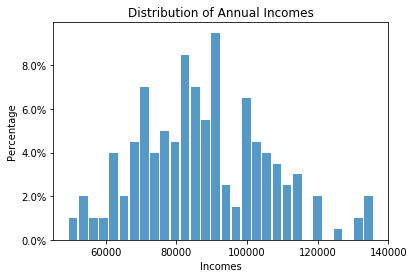

In [43]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
w = np.ones_like(df.income)/len(df.income)
plt.hist(df.income, bins=30, alpha=0.75, rwidth=0.85,weights=w)
to_percent = lambda v, pos: str(v*100)+'%'
formatter = mticker.FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
plt.xlabel('Incomes')
plt.ylabel('Percentage')
plt.title('Distribution of Annual Incomes')
plt.show()

#### Part(b)

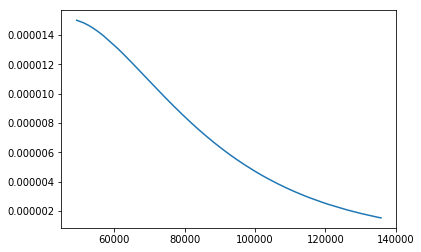

In [44]:
from scipy.stats import lognorm
df['pdf'] = lognorm.pdf(df.income, s=0.5, scale=np.exp(11))
mask = (df.income>=0) & (df.income<=150000)
df1 = df[mask].sort_values(['income'])
plt.plot(df1.income, df1.pdf)
plt.show()

In [48]:
#Define function that generates a log-normal pdf
def ln_pdf(x, mu, sigma):
    val_pdf = 1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*(sigma**2)))
    return val_pdf

def log_ln_pdf(x, mu, sigma):
    log_val_pdf = np.log(ln_pdf(x, mu, sigma))
    return log_val_pdf.sum()

log_lik = log_ln_pdf(df1.income, 11, 0.5)
print('Given the parameterization and data, the log likelihood value is ', log_lik)

Given the parameterization and data, the log likelihood value is  -2385.856997808558


#### Part(c)

In [55]:
import scipy.optimize as opt
#The criterion function

def crit(params, x):
    mu, sigma = params
    #print(x, mu, sigma)
    sum = -log_ln_pdf(x, mu, sigma)
    #print(mu, sigma, sum)
    return sum

#Initial guess of mu and sigma
mu_init = 11  # mu_2
sig_init = 0.5  # sig_2
params_init = np.array([mu_init, sig_init])
#bnds = ((None, None), (1e-10, None))
x = df.income[mask]
np.seterr(divide = 'ignore')
results = opt.minimize(crit, params_init, x, bounds=bnds)
mu, sigma = results.x
Hess = results.hess_inv.todense()
fval = -results.fun
print('The optimized result is mu = {:.2f}, sigma = {:.2f}'.format(mu, sigma))
print('The value of the likelihood function is ', fval)
print('The inverse Hessian matrix is ', Hess)

The optimized result is mu = 11.50, sigma = 0.31
The value of the likelihood function is  -2285.899954411707
The inverse Hessian matrix is  [[ 4.59466269e-04 -6.65453258e-05]
 [-6.65453258e-05  1.71221450e-03]]


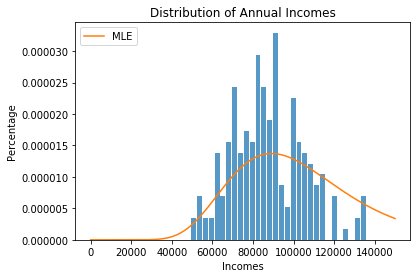

In [66]:
income_vector = np.linspace(0, 150000, 1000)
p = lognorm.pdf(income_vector, s=sigma, scale=np.exp(mu))
count, bins, ignored = plt.hist(df.income, bins=30, alpha=0.75, rwidth=0.85,density=True)
plt.plot(income_vector, p, label='MLE')
#to_percent = lambda v, pos: str(v*100)+'%'
#formatter = mticker.FuncFormatter(to_percent)
#plt.gca().yaxis.set_major_formatter(formatter)
plt.xlabel('Incomes')
plt.ylabel('Percentage')
plt.title('Distribution of Annual Incomes')
plt.legend(loc='upper left')
plt.show()

#### Part(d)

In [33]:
from scipy.stats import chi2
mu0, sigma0 = 11, 0.5
log_lik_h0 = log_ln_pdf(df.income, mu0, sigma0)
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_ln_pdf(df.income, mu, sigma)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -2385.8569978385995
MLE log likelihood -2285.8999679678154
likelihood ratio value 199.91405974156805
chi squared of H0 with 2 degrees of freedom p-value =  0.0


#### Part(e)

In [34]:
p1 = 1 - lognorm.cdf(100000, s=sigma, scale=np.exp(mu))
p2 = lognorm.cdf(75000, s=sigma, scale=np.exp(mu))
print('Probability of earning more than $100,000 is {:.2f}'.format(p1))
print('Probability of earning less than $75,000 is {:.2f}'.format(p2))

Probability of earning more than $100,000 is 0.48
Probability of earning less than $75,000 is 0.19


### Question 2

In [35]:
#Load the data
text = []
with open('data/sick.txt') as f:
    for line in f:
        text.append(line.rsplit()[0].split(','))
text = np.array(text)
df = pd.DataFrame(text[1:], columns=['sick', 'age', 'children', 'temp_winter']).astype('float64')
df.head()

,sick,age,children,temp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


#### Part(a)

In [36]:
from scipy.stats import norm
import math
def norm_pdf(x, sigma):
    p = norm.pdf(x, 0, sigma)
    return p

def log_lik_norm(y, x1, x2, x3, b0, b1, b2, b3, sigma):
    res = y - b0 - x1*b1 - x2*b2 - x3*b3
    p = norm_pdf(res, sigma)
    log_lik = np.log(p)
    return log_lik.sum()

def crit(params, *args):
    b0, b1, b2, b3, sigma = params
    y, x1, x2, x3 = args
    neg_log_lik = -log_lik_norm(y, x1, x2, x3, b0, b1, b2, b3, sigma)
    #print(b0, b1, b2, b3, neg_log_lik)
    return neg_log_lik

In [37]:
b0_init, b1_init, b2_init, b3_init = (0.2,0,0,0)
sigma_init = 1
y = df.sick
x1, x2, x3 = df['age'], df['children'], df['temp_winter']

results = opt.minimize(crit, np.array([b0_init, b1_init, b2_init, b3_init, sigma_init]), (y, x1, x2, x3), options={'disp': True})
results

         Current function value: -876.865046
         Iterations: 40
         Function evaluations: 1346
         Gradient evaluations: 190


      fun: -876.8650462890186
 hess_inv: array([[ 9.27573453e-07,  6.91342071e-09, -1.51802765e-07,
        -2.07231322e-08, -4.47965526e-10],
       [ 6.91342071e-09,  4.03650482e-09, -3.63332995e-08,
        -2.50514048e-09,  2.52215386e-11],
       [-1.51802765e-07, -3.63332995e-08,  3.73970591e-07,
         2.28278928e-08, -3.66044604e-10],
       [-2.07231322e-08, -2.50514048e-09,  2.28278928e-08,
         1.91740562e-09,  2.28426437e-12],
       [-4.47965526e-10,  2.52215386e-11, -3.66044604e-10,
         2.28426437e-12,  2.27938897e-08]])
      jac: array([0.00152588, 0.07671356, 0.00409698, 0.06681824, 0.00237274])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1346
      nit: 40
     njev: 190
   status: 2
  success: False
        x: array([ 0.25164638,  0.01293335,  0.40050205, -0.00999167,  0.00301768])

In [38]:
#This section is to show OLS estimation results
from sklearn.linear_model import LinearRegression

X = df[['age','children','temp_winter']]
y = df['sick']
reg = LinearRegression(True).fit(X, y)
reg.intercept_, reg.coef_

(0.25164137472289494, array([ 0.01293366,  0.40049939, -0.00999174]))

In [39]:
b0, b1, b2, b3, sigma = results.x
Hess = results.hess_inv
fval = -results.fun
print('The optimized result is b0 = {:.2f}, b1 = {:.2f}, b2 = {:.2f}, b3 = {:.2f}, sigma = {:.2f}'.format(b0, b1, b2, b3, sigma))
print('The value of the likelihood function is ', fval)
print('The inverse Hessian matrix is ', Hess) #Nelder-mead does not report hessian matrix

The optimized result is b0 = 0.25, b1 = 0.01, b2 = 0.40, b3 = -0.01, sigma = 0.00
The value of the likelihood function is  876.8650462890186
The inverse Hessian matrix is  [[ 9.27573453e-07  6.91342071e-09 -1.51802765e-07 -2.07231322e-08
  -4.47965526e-10]
 [ 6.91342071e-09  4.03650482e-09 -3.63332995e-08 -2.50514048e-09
   2.52215386e-11]
 [-1.51802765e-07 -3.63332995e-08  3.73970591e-07  2.28278928e-08
  -3.66044604e-10]
 [-2.07231322e-08 -2.50514048e-09  2.28278928e-08  1.91740562e-09
   2.28426437e-12]
 [-4.47965526e-10  2.52215386e-11 -3.66044604e-10  2.28426437e-12
   2.27938897e-08]]


#### Part(b)

In [41]:
b0_0, b1_0, b2_0, b3_0, sigma_0 = 0, 0, 0, 0, 0.1
log_lik_h0 = log_lik_norm(y, x1, x2, x3, b0_0, b1_0, b2_0, b3_0, sigma_0)
print('Hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_lik_norm(y, x1, x2, x3, b0, b1, b2, b3, sigma)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('Likelihood ratio value', LR_val)
pval_h0 = 1.0 - chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

Hypothesis value log likelihood -12425.700688042125
MLE log likelihood 876.8650462890186
Likelihood ratio value 26605.131468662286
chi squared of H0 with 2 degrees of freedom p-value =  0.0
